In [781]:
import pandas as pd
df = pd.read_csv('Processed_Machine_Data.csv')

In [782]:
df_cleaned = pd.get_dummies(df, columns=['Type'])
print(df.head())

   UDI Product ID Type  Air temperature [K]  Process temperature [K]  \
0    1     M14860    M                298.1                    308.6   
1    2     L47181    L                298.2                    308.7   
2    3     L47182    L                298.1                    308.5   
3    4     L47183    L                298.2                    308.6   
4    5     L47184    L                298.2                    308.7   

   Rotational speed [rpm]  Torque [Nm]  Tool wear [min]  Replace  \
0                    1551         42.8                0        0   
1                    1408         46.3                3        0   
2                    1498         49.4                5        0   
3                    1433         39.5                7        0   
4                    1408         40.0                9        0   

   Machine failure  TWF  HDF  PWF  OSF  RNF  
0                0    0    0    0    0    0  
1                0    0    0    0    0    0  
2                0  

In [783]:
import numpy as np

df_cleaned['Temperature difference'] = df_cleaned['Process temperature [K]'] - df_cleaned['Air temperature [K]']
df_cleaned['Power'] = df_cleaned['Torque [Nm]'] * df_cleaned['Rotational speed [rpm]'] * (2 * np.pi / 60)
df_cleaned['Torque per RPM'] = df_cleaned['Torque [Nm]'] / df_cleaned['Rotational speed [rpm]']
df_cleaned['Temperature ratio'] = df_cleaned['Air temperature [K]'] / df_cleaned['Process temperature [K]']
df_cleaned['Tool_wear_diff'] = df_cleaned['Tool wear [min]'].diff().fillna(0)
df_cleaned['Tool_wear_roll_mean'] = df_cleaned['Tool wear [min]'].rolling(window=3, min_periods=1).mean()
df_cleaned['Tool_wear_roll_std'] = df_cleaned['Tool wear [min]'].rolling(window=3, min_periods=1).std().fillna(0)
df_cleaned['TWF_x_wear'] = df_cleaned['TWF'] * df_cleaned['Tool wear [min]']
df_cleaned['Time index'] = np.arange(len(df_cleaned))
df_cleaned['lv'] = pd.cut(
    df['Tool wear [min]'],
    bins=[0, 100, 200, 260],
    labels=['低', '中', '高'],
    right=True,
    include_lowest=True
)


df_cleaned['Wear per RPM'] = df_cleaned['Tool wear [min]'] / df_cleaned['Rotational speed [rpm]']
df_cleaned['Wear_rate_per_hour'] = df_cleaned['Tool wear [min]'] / 60
df_cleaned['Cumulative_wear'] = df_cleaned['Tool wear [min]'].cumsum()
df_cleaned['Wear_acceleration'] = df_cleaned['Tool wear [min]'].diff().fillna(0)
df_cleaned['Wear_per_torque'] = df_cleaned['Tool wear [min]'] / (df_cleaned['Torque [Nm]'] + 0.1)
df_cleaned['Wear_torque_interaction'] = df_cleaned['Tool wear [min]'] * df_cleaned['Torque [Nm]']
df_cleaned['Wear_power_ratio'] = df_cleaned['Tool wear [min]'] / (df_cleaned['Power'] + 0.1)

from sklearn.preprocessing import OrdinalEncoder
df_cleaned['lv_code'] = OrdinalEncoder(categories=[['低', '中', '高']]).fit_transform(df_cleaned[['lv']])



   Air temperature [K]  Process temperature [K]  Rotational speed [rpm]  \
0                298.1                    308.6                    1551   
1                298.2                    308.7                    1408   
2                298.1                    308.5                    1498   
3                298.2                    308.6                    1433   
4                298.2                    308.7                    1408   

   Torque [Nm]  Tool wear [min]  Machine failure  TWF  HDF  PWF  OSF  ...  \
0         42.8                0                0    0    0    0    0  ...   
1         46.3                3                0    0    0    0    0  ...   
2         49.4                5                0    0    0    0    0  ...   
3         39.5                7                0    0    0    0    0  ...   
4         40.0                9                0    0    0    0    0  ...   

   Tool_wear_roll_std  TWF_x_wear  Time index  Wear per RPM  \
0            0.000000  

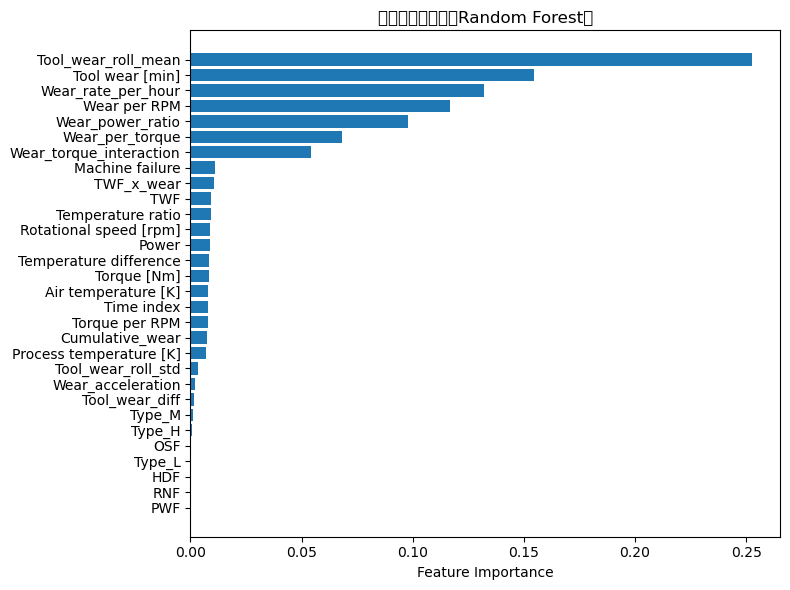

In [784]:
from sklearn.ensemble import RandomForestClassifier
import pandas as pd
import matplotlib.pyplot as plt


X = df_cleaned.drop(columns=['Replace', 'UDI', 'lv','lv_code', 'Product ID'])
y = df_cleaned['Replace']


print(X.head())
# 建立隨機森林模型
rf = RandomForestClassifier(n_estimators=100, random_state=42, class_weight='balanced')
rf.fit(X, y)

# 取得特徵重要性
importances = rf.feature_importances_
feature_importance_df = pd.DataFrame({
    'Feature': X.columns,
    'Importance': importances
}).sort_values(by='Importance', ascending=False)

# 繪製視覺化
plt.figure(figsize=(8, 6))
plt.barh(feature_importance_df['Feature'], feature_importance_df['Importance'])
plt.gca().invert_yaxis()
plt.xlabel("Feature Importance")
plt.title("特徵重要性排序（Random Forest）")
plt.tight_layout()
plt.show()

In [785]:
from sklearn.model_selection import train_test_split

# 選定特徵與標籤
features = [
    'Tool_wear_roll_mean',
    'Wear per RPM',
    'Tool wear [min]',
    'Machine failure',
    'TWF_x_wear',
    'Rotational speed [rpm]',
    'Torque [Nm]', 
    'Power', 
    'Torque per RPM',
    'Temperature ratio',
    'lv_code'

    #'Wear_rate_per_hour',
    #'Wear_power_ratio',
    #'Wear_per_torque',
    #'Wear_torque_interaction',
]

target_col = 'Replace'

X = df_cleaned[features]
y = df_cleaned[target_col]



# 切割資料集（80% 訓練集，20% 測試集），並維持標籤分布
X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.2, random_state=42, stratify=y
)

print('訓練集筆數:', X_train.shape[0])
print('測試集筆數:', X_test.shape[0])

訓練集筆數: 8000
測試集筆數: 2000


=== 交叉驗證過程 ===
第1折: 最佳門檻=0.89, F1-score=0.500
第2折: 最佳門檻=0.84, F1-score=0.286
第3折: 最佳門檻=0.61, F1-score=0.343
第4折: 最佳門檻=0.89, F1-score=0.500
第5折: 最佳門檻=0.81, F1-score=0.706
第6折: 最佳門檻=0.84, F1-score=0.706
第7折: 最佳門檻=0.88, F1-score=0.625
第8折: 最佳門檻=0.87, F1-score=0.667
第9折: 最佳門檻=0.81, F1-score=0.462
第10折: 最佳門檻=0.82, F1-score=0.421

最佳門檻平均值為 0.83
所有折中最佳 F1-score (失敗類): 0.706

=== 測試集 ===
最佳門檻為 0.83，此時 F1-score (失敗類) 為 0.500

              precision    recall  f1-score   support

           0       0.99      1.00      1.00      1976
           1       0.75      0.38      0.50        24

    accuracy                           0.99      2000
   macro avg       0.87      0.69      0.75      2000
weighted avg       0.99      0.99      0.99      2000



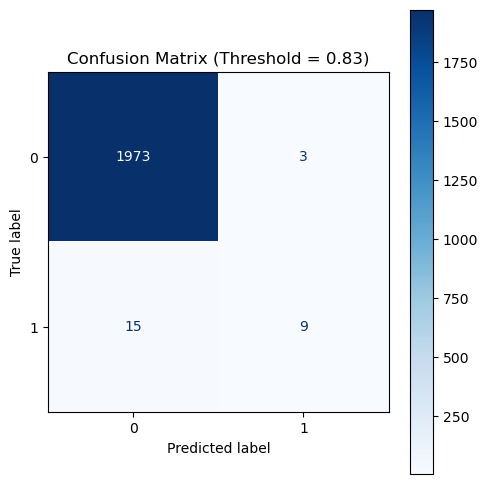

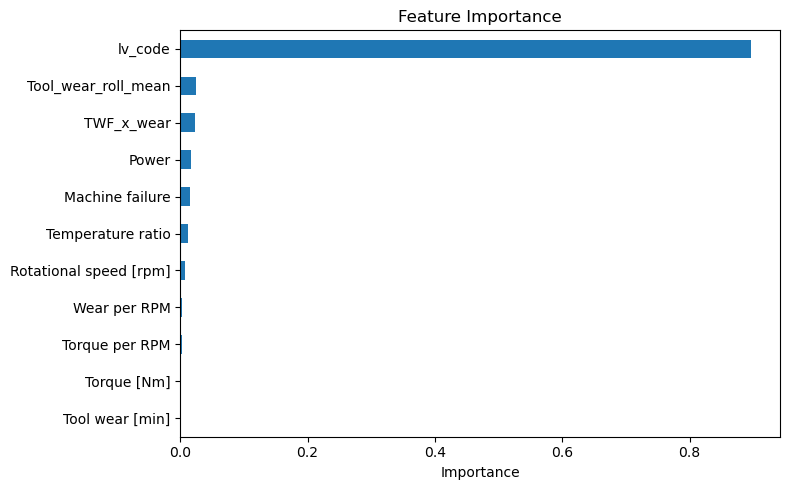

In [786]:
from sklearn.tree import DecisionTreeClassifier
import numpy as np
from imblearn.combine import SMOTETomek, SMOTEENN
import matplotlib.pyplot as plt
from sklearn.model_selection import StratifiedKFold
from sklearn.metrics import roc_curve, auc, f1_score, classification_report, confusion_matrix, ConfusionMatrixDisplay
from sklearn.ensemble import RandomForestClassifier
from imblearn.pipeline import Pipeline

# 建立 pipeline（保證每折都只在訓練集做 SMOTE）
pipe = Pipeline([
    ('smote', SMOTETomek(sampling_strategy=0.20, random_state=42)),
    ('clf', DecisionTreeClassifier(
        random_state=7414,
        class_weight={0:1, 1:1.5},
        max_depth=7,
        max_features=4,
        min_samples_leaf=5,
        min_samples_split=70,
        ccp_alpha=0,
        criterion='entropy',
        splitter='best'
    ))
])

skf = StratifiedKFold(n_splits=10, shuffle=True, random_state=42)
thresholds = np.arange(0.1, 0.91, 0.01)

f1_list = []
best_thresholds = []

print("=== 交叉驗證過程 ===")
for fold, (train_idx, valid_idx) in enumerate(skf.split(X_train, y_train), 1):
    X_tr, X_val = X_train.iloc[train_idx], X_train.iloc[valid_idx]
    y_tr, y_val = y_train.iloc[train_idx], y_train.iloc[valid_idx]
    
    pipe.fit(X_tr, y_tr)
    y_proba = pipe.predict_proba(X_val)[:, 1]

    best_f1 = 0
    best_thres = 0.5
    for thres in thresholds:
        y_pred = (y_proba >= thres).astype(int)
        f1 = f1_score(y_val, y_pred, pos_label=1)
        if f1 > best_f1:
            best_f1 = f1
            best_thres = thres
    print(f"第{fold}折: 最佳門檻={best_thres:.2f}, F1-score={best_f1:.3f}")
    f1_list.append(best_f1)
    best_thresholds.append(best_thres)

# 找出所有折最佳門檻的平均值
final_best_thres = np.mean(best_thresholds)
print(f"\n最佳門檻平均值為 {final_best_thres:.2f}")
print(f"所有折中最佳 F1-score (失敗類): {np.max(f1_list):.3f}")

# 用最佳門檻評估測試集
pipe.fit(X_train, y_train)
y_proba_test = pipe.predict_proba(X_test)[:, 1]


y_pred_best = (y_proba_test >= final_best_thres).astype(int)

print(f"\n=== 測試集 ===")
print(f"最佳門檻為 {final_best_thres:.2f}，此時 F1-score (失敗類) 為 {f1_score(y_test, y_pred_best, pos_label=1):.3f}\n")
print(classification_report(y_test, y_pred_best, digits=2))



# 混淆矩陣
cm = confusion_matrix(y_test, y_pred_best)
disp = ConfusionMatrixDisplay(confusion_matrix=cm)
fig, ax = plt.subplots(figsize=(5, 5))
disp.plot(ax=ax, cmap='Blues', values_format='d')  # 'd' 表示整數顯示
plt.title(f"Confusion Matrix (Threshold = {final_best_thres:.2f})")
plt.tight_layout()
plt.show()
import pandas as pd
# ===== 5. 特徵重要性視覺化 =====
clf = pipe.named_steps['clf']
importances = pd.Series(clf.feature_importances_, index=X_train.columns)
importances.sort_values(ascending=True).plot.barh(figsize=(8, 5), title="Feature Importance")
plt.xlabel('Importance')
plt.tight_layout()
plt.show()